In [1]:
import os
from os.path import exists

import anchor
# import anchor.anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *


In [2]:
data_path = "simulationVictorTopological/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-csr.csv"
feature_labels = ['x','y']
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"CP_SVM_safe.sav")

test = pd.read_csv(data_path+"test_cp.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)

In [3]:
test.describe()

,x,y,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.992839,5.128687,-0.064000,-0.158000
std,2.892676,4.064634,0.998449,0.987933
min,0.026555,-4.190374,-1.000000,-1.000000
25%,2.477133,2.301952,-1.000000,-1.000000
50%,4.842608,5.107767,-1.000000,-1.000000
75%,7.582407,8.009389,1.000000,1.000000
max,9.998768,14.830205,1.000000,1.000000


In [4]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,y > 5.00,0.4984,0.845934,-1.0,-1.0,-1.0
1,1,y <= 8.02,0.7518,0.578110,1.0,1.0,1.0
2,2,x <= 2.47,0.2554,0.842893,-1.0,-1.0,-1.0
3,3,y <= 5.00,0.4987,0.559721,1.0,1.0,1.0
4,4,y > 5.00,0.5082,0.844262,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...
979,995,x <= 2.47,0.2503,0.836420,-1.0,-1.0,-1.0
980,996,x <= 2.47,0.2350,0.856698,-1.0,-1.0,1.0
981,997,y <= 8.02,0.7500,0.566757,1.0,1.0,1.0
982,998,y > 5.00,0.4902,0.825352,-1.0,-1.0,-1.0


In [5]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
y <= 8.02                335
y <= 5.00                 72
x > 5.12 AND y > 2.17      6
x > 7.65 AND y > 2.17      5
x > 7.65 AND y > 5.00      2
Name: count, dtype: int64

In [6]:
model.get_params()

{'alpha': array([ 1.53751795e-05,  5.00012163e-01,  4.70027443e-06, ...,
         2.44375993e-02, -1.61108163e-06,  8.18330832e-03]),
 'b': array([-0.00040652]),
 'b_eps': 0.9664748294901703,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

# Candidate selection

Text(0, 0.5, 'Count')

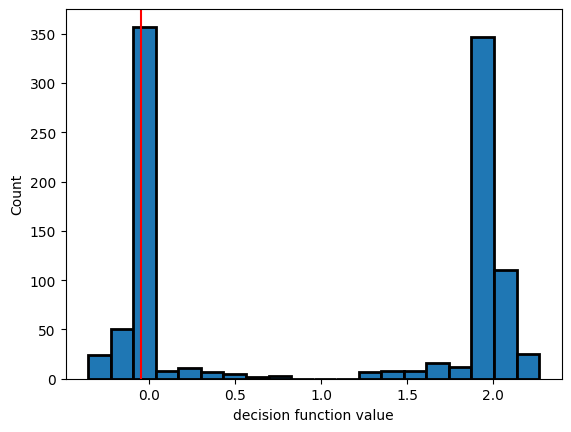

In [7]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [8]:
min(d_test)

-0.35547222402262457

In [10]:
max(d_test)

2.2661482191067783

In [9]:
model.b_eps

0.9664748294901703

In [11]:
d_thresh = 0.05

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 241


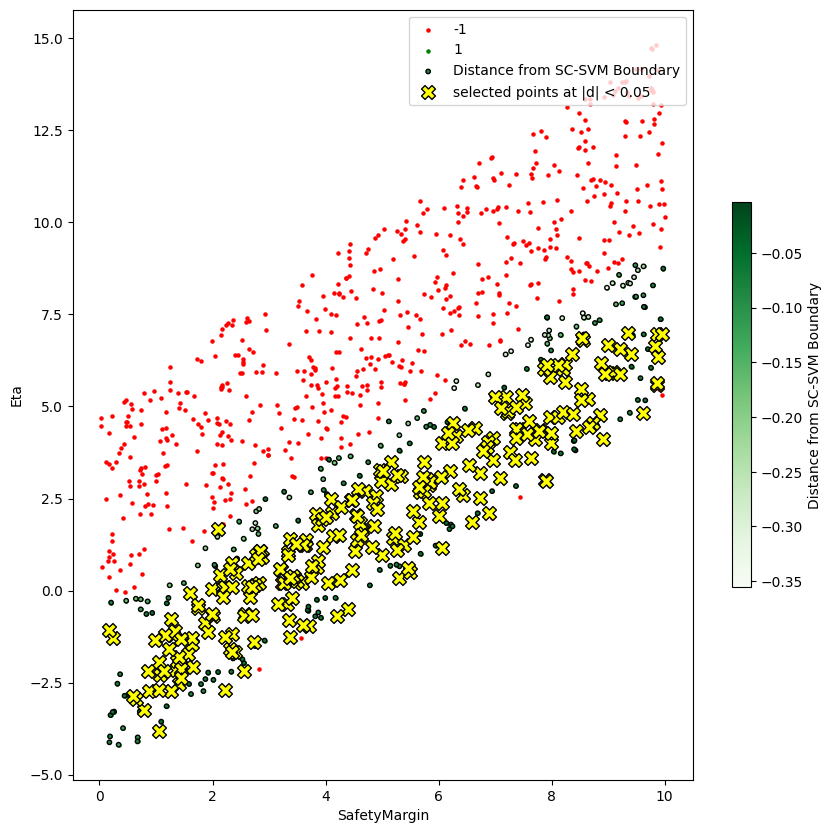

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Gráficos 2D sin la tercera variable (Z)
sc0 = ax.scatter(X_test[:, 0][y_cp_test == -1], X_test[:, 1][y_cp_test == -1], s=5, c="red", label="-1")
scsafe = ax.scatter(X_test[:, 0][y_cp_test == 1], X_test[:, 1][y_cp_test == 1], s=5, c="green", label="1")

sc1 = ax.scatter(X_test[:, 0][y_cp_test == 1], X_test[:, 1][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1],
                 cmap="Greens", edgecolors="k", label="Distance from SC-SVM Boundary")

sc2 = ax.scatter(X_test[list(border_points_idx), 0], X_test[list(border_points_idx), 1], s=100, marker='X',
                 facecolors="yellow", edgecolors="k", label=f"selected points at |d| < {d_thresh}")

# Etiquetas de los ejes
ax.set_xlabel("SafetyMargin")
ax.set_ylabel("Eta")

# Leyenda y barra de color
ax.legend(loc="upper right")
plt.colorbar(sc1, label="Distance from SC-SVM Boundary", shrink=0.5)

plt.show()


# Select the anchors for the candidate points

In [14]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [15]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [16]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
# '''
# # define a threshold for filtering on covering
# covering_threshold = 0.1

# rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

# rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

# rules_selected
# '''

In [17]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
y <= 8.02    201
y <= 5.00     39
Name: count, dtype: int64

# Performance Evaluation


In [18]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        err = fptot/(tntot+fptot)
        print(f"precision: {prec}, covering: {cov}, error: {err}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = [part.strip('()') for part in condition_part.split()]
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass

# SafetyMargin > 0.05 AND Tau <= 0.25 AND Eta > 0.25


In [19]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
6,6,y <= 8.02,0.7541,0.572207,1.0,1.0,1.0
81,81,y <= 5.00,0.5025,0.562032,1.0,1.0,1.0


# Evaluation on true labels

In [20]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: y <= 8.02
tp = 444, tn = 226, fp = 306, fn = 24
precision: 0.592, covering: 0.9487179487179487, error: 0.575187969924812, accuracy: 0.67, f1: 0.729064039408867

rule: y <= 5.00
tp = 354, tn = 392, fp = 140, fn = 114
precision: 0.7165991902834008, covering: 0.7564102564102564, error: 0.2631578947368421, accuracy: 0.746, f1: 0.735966735966736



# evaluation on safety checker labels

In [21]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: y <= 8.02
tp = 408, tn = 237, fp = 342, fn = 13
precision: 0.544, covering: 0.9691211401425178, error: 0.5906735751295337, accuracy: 0.645, f1: 0.6968403074295474

rule: y <= 5.00
tp = 330, tn = 415, fp = 164, fn = 91
precision: 0.6680161943319838, covering: 0.7838479809976246, error: 0.28324697754749567, accuracy: 0.745, f1: 0.7213114754098361



**Evaluate the $\lor$ of the rules**

In [23]:
verified1 = (X_test[:,1] <= 8.02) 

verified2 = (X_test[:,1] <= 5) 

verified_or = verified1|verified2

prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")  

tp = 408, tn = 237, fp = 342, fn = 13
precision: 0.544, covering: 0.9691211401425178, accuracy: 0.645, f1: 0.6968403074295474, error: 0.456


# Evaluation on true labels (Safety sim instead of only deadlock)